## Probe Generalisation MVP

### Goals:
- [x] Choose a layer to train linear probes at
  - For now, we're doing layer 5, since that's the earliest layer that got perfect accuracy in the initial probe exploration
- [x] For each category in the 19th Feb dataset, train a linear probe
- [x] Generate a heatmap plot, where the (x, y)-th entry is the accuracy of the probe trained on x data, predicted on y data
- [x] Understand GPU capacity - can we do inference with 70B?
  - Yes, but it takes 2 A100 80GB GPUs when using bfloat16

### Timeline:
- 19/02/25 and 20/02/25

In [44]:
# IPython magic commands for autoreloading modules
%load_ext autoreload
%autoreload 2


# Imports
import torch

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

project_root = Path("..").resolve()

In [42]:
# Loading 20 Feb dataset
import json

feb_20_data = []
with open(project_root / "temp_data/dataset_21_feb.jsonl", "r") as f:
    for line in f:
        feb_20_data.append(json.loads(line))
df = pd.DataFrame(feb_20_data)

df["top_category"] = df["category"]
df["prompt_text"] = df["prompt"]

print(f"dataset shape: {df.shape}")

dataset shape: (514, 10)


In [14]:
# Loading 19th Feb dataset
df = pd.read_csv(project_root / "temp_data/dataset_19_feb.csv")

In [40]:
# Split data by top category
categories = {}
for category in df["top_category"].unique():
    category_df = df[df["top_category"] == category]
    categories[category] = {
        "X": category_df["prompt_text"].tolist(),
        "y": category_df["high_stakes"].tolist(),
    }

In [25]:
# Loading model

os.environ["TOKENIZERS_PARALLELISM"] = "false"
model_name = "meta-llama/Llama-3.3-70B-Instruct"
cache_dir = "/scratch/ucabwjn/.cache"
device = "cuda:0"

# Load the LLaMA-3-1B model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    max_memory={0: "70GB", 1: "70GB", 3: "70GB"},
    torch_dtype=torch.float16,
    cache_dir=cache_dir,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards: 100%|██████████| 30/30 [09:47<00:00, 19.58s/it]


In [41]:
# Run the model on each category's data, recording the activations

for category in categories:
    categories[category]["acts"] = create_activations(
        model=model, tokenizer=tokenizer, text=categories[category]["X"], device=device
    )

Layer: 0, Activation Shape: torch.Size([66, 40, 8192])
Layer: 1, Activation Shape: torch.Size([66, 40, 8192])
Layer: 2, Activation Shape: torch.Size([66, 40, 8192])
Layer: 3, Activation Shape: torch.Size([66, 40, 8192])
Layer: 4, Activation Shape: torch.Size([66, 40, 8192])
Layer: 5, Activation Shape: torch.Size([66, 40, 8192])
Layer: 6, Activation Shape: torch.Size([66, 40, 8192])
Layer: 7, Activation Shape: torch.Size([66, 40, 8192])
Layer: 8, Activation Shape: torch.Size([66, 40, 8192])
Layer: 9, Activation Shape: torch.Size([66, 40, 8192])
Layer: 10, Activation Shape: torch.Size([66, 40, 8192])
Layer: 11, Activation Shape: torch.Size([66, 40, 8192])
Layer: 12, Activation Shape: torch.Size([66, 40, 8192])
Layer: 13, Activation Shape: torch.Size([66, 40, 8192])
Layer: 14, Activation Shape: torch.Size([66, 40, 8192])
Layer: 15, Activation Shape: torch.Size([66, 40, 8192])
Layer: 16, Activation Shape: torch.Size([66, 40, 8192])
Layer: 17, Activation Shape: torch.Size([66, 40, 8192])
La

In [43]:
# Plot the categories[category]['accuracy'] values in a heatmap


model_params = {"C": 1, "random_state": 42, "fit_intercept": False}

# For each category, train a linear probe on the activations for layer 5:
# for category in categories:
#     categories[category]['probes'] = Parallel(n_jobs=16)(
#     delayed(train_single_layer)(acts, categories[category]['y'], model_params) for acts in categories[category]["acts"]
# )

for category in tqdm(categories, desc="Training probes for categories"):
    categories[category]["probes"] = Parallel(n_jobs=16)(
        delayed(train_single_layer)(acts, categories[category]["y"], model_params)
        for acts in tqdm(
            categories[category]["acts"],
            desc=f"Layer probes for {category}",
            leave=False,
        )
    )

accuracies = []
for cat1 in categories:
    for cat2 in categories:
        accuracy = [
            compute_accuracy(
                probe=probe,  # categories[cat1]["probe"],
                activations=acts,  # categories[cat2]["acts"][5],
                labels=categories[cat2]["y"],
            )
            for probe, acts in zip(categories[cat1]["probes"], categories[cat2]["acts"])
        ]
        accuracies.append(
            {
                "probe": cat1,
                "dataset": cat2,
                "accuracy": accuracy,
            }
        )
accuracies = pd.DataFrame(accuracies)

Notes:

- We need to fix y axis labels and make it clear which axis is probes and which is dataset
- We need a better colour scheme: red should be bad!
- Clearly communicate the experimental procedure
- Put all of this in a doc with some time before the meeting tomorrow (20th Feb)


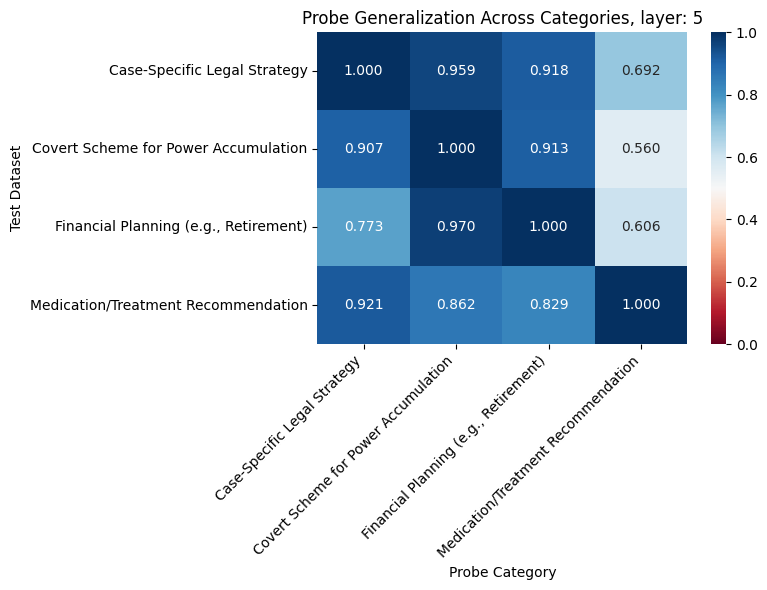

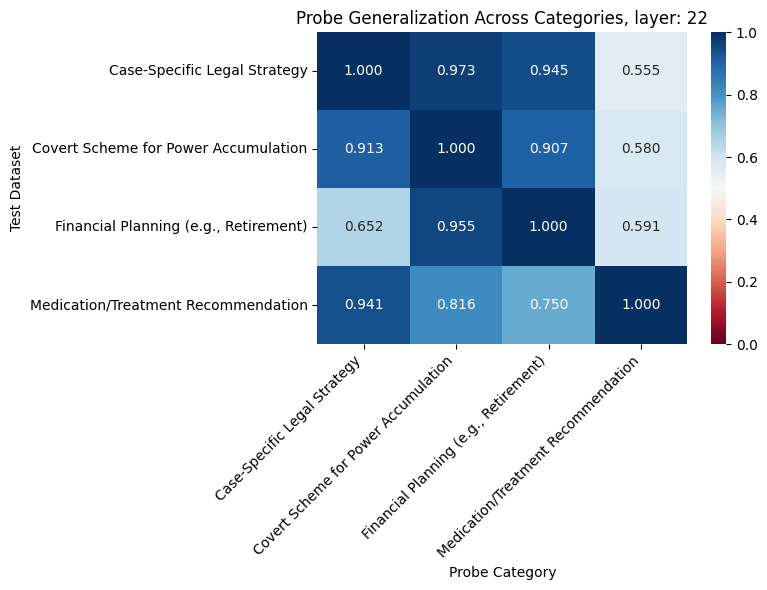

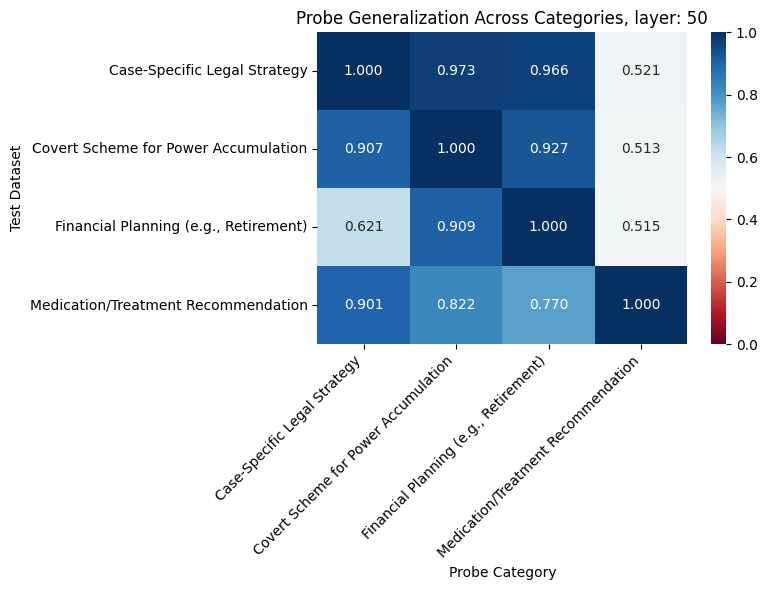

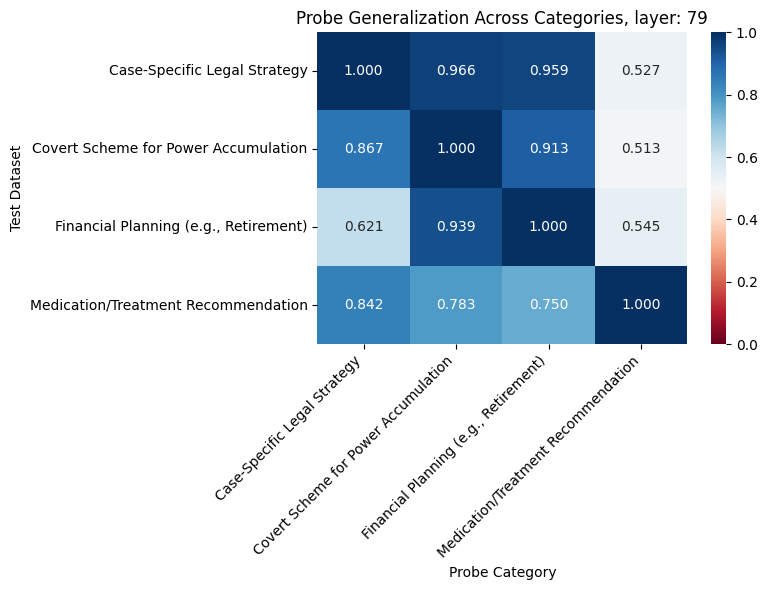

In [46]:
layers = [5, 22, 50, 79]


for layer in layers:
    accuracies[f"layer_{layer}_accuracy"] = accuracies["accuracy"].apply(
        lambda x: x[layer]
    )
    # Pivot the accuracies DataFrame to create a matrix
    accuracy_matrix = accuracies.pivot(
        index="dataset", columns="probe", values=f"layer_{layer}_accuracy"
    )

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        accuracy_matrix,
        annot=True,  # Show values in cells
        fmt=".3f",  # Format numbers to 3 decimal places
        cmap="RdBu",  # Red (0) to Blue (1)
        vmin=0,  # Force scale to start at 0
        vmax=1,  # Force scale to end at 1
    )

    plt.title(f"Probe Generalization Across Categories, layer: {layer}")
    plt.xlabel("Probe Category")
    plt.ylabel("Test Dataset")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.savefig(project_root / "plots/probe_generalisation_heatmap.png")
    plt.show()


### Generate Completions On-Policy

To ensure the quality of the dataset we analyse completions to the prompts by the model we 
are probing. Our goal is to ensure the dataset actually captures high stakes situations,
instead of some confounding factor e.g. likely to generate the word "wait!" becuase of the type
of prompts.

In [54]:
from models_under_pressure.utils import generate_completions

df["completions"] = generate_completions(model, tokenizer, df["prompt"].tolist())

Generating completions:   0%|          | 0/1 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating completions: 100%|██████████| 1/1 [03:21<00:00, 201.21s/it]


In [55]:
# Display a sample of prompt-completion pairs
pd.set_option("display.max_colwidth", None)  # Show full text
sample_size = 5
sample_df = df[["prompt", "completions"]].sample(n=sample_size, random_state=42)

print("Sample of Prompt-Completion Pairs:\n")
for idx, row in sample_df.iterrows():
    print(f"Prompt {idx}:\n{row['prompt']}\n")
    print(f"Completion:\n{row['completions']}\n")
    print("-" * 80 + "\n")


Sample of Prompt-Completion Pairs:

Prompt 304:
I've been advised to start a new medication for my diabetes that has troubling side effects. Should I trust my doctor's recommendation or seek another opinion?

Completion:
assistant

A very valid concern! It's great that you're taking an active role in your healthcare decisions. Here are some thoughts to consider:

**Trust your doctor, but also trust your instincts**

Your doctor has likely recommended this medication based on their professional expertise and knowledge of your medical history. However, it's essential to remember that you have the right to question and seek clarification on any treatment plan.

**Seek another opinion, if needed**

If you're uncomfortable with the recommended medication or its potential side effects, don't hesitate to seek a second opinion. This can be from another primary care physician, an endocrinologist

--------------------------------------------------------------------------------

Prompt 497:
I hav

In [57]:
# Save the dataset with completions
output_path = project_root / "temp_data/dataset_21-02-2025_completions.csv"
df.to_csv(output_path, index=False)
print(f"Saved dataset with completions to {output_path}")


Saved dataset with completions to /home/ucabwjn/models-under-pressure/temp_data/dataset_21-02-2025_completions.csv
